## 0. IMPORTS

In [40]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torchvision
from torchvision import transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import torchvision.transforms.functional as F

import imageio.v3 as iio
import ipympl
import skimage as ski

import cv2

## 1. LOAD DATA

In [2]:
images = sorted(os.listdir("C:/Users/kubaw/Desktop/DELFT/CORE/satellite_predictions/Dataset2/Images/Destroyed"))
masks = sorted(os.listdir("C:/Users/kubaw/Desktop/DELFT/CORE/satellite_predictions/Dataset2/Masks/Destroyed"))

In [3]:
idx = 15

img = Image.open("C:/Users/kubaw/Desktop/DELFT/CORE/satellite_predictions/Dataset2/Images/Destroyed/" + images[idx]).convert("RGB")
mask = Image.open("C:/Users/kubaw/Desktop/DELFT/CORE/satellite_predictions/Dataset2/Masks/Destroyed/" + masks[idx])

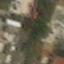

In [4]:
img

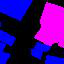

In [5]:
mask

In [6]:
np.shape(mask)

(64, 64, 3)

In [7]:
mask_arr = np.array(mask)
np.set_printoptions(threshold=100)

### 1.1 Transform one mask to 1 dim arrays

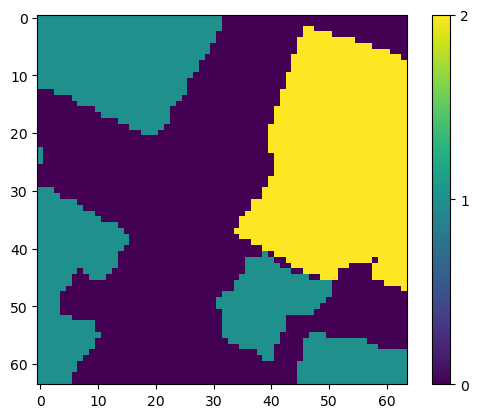

In [8]:
# Define color thresholds for blue and magenta
blue_lower = np.array([0, 0, 100], dtype=np.uint8)
blue_upper = np.array([50, 80, 255], dtype=np.uint8)

magenta_lower = np.array([120, 0, 120], dtype=np.uint8)
magenta_upper = np.array([255, 100, 255], dtype=np.uint8)

# Create masks for blue and magenta regions
blue_mask = cv2.inRange(mask_arr, blue_lower, blue_upper)
magenta_mask = cv2.inRange(mask_arr, magenta_lower, magenta_upper)

# Combine the masks to get the final transformed mask
transformed_mask = np.zeros_like(blue_mask)
transformed_mask[blue_mask > 0] = 1  # Object 1 (Blue)
transformed_mask[magenta_mask > 0] = 2  # Object 2 (Magenta)

# Display the transformed mask using matplotlib
plt.imshow(transformed_mask, cmap='viridis', vmin=0, vmax=2)  # Adjust the cmap as needed
plt.colorbar(ticks=[0, 1, 2])
plt.show()



In [9]:
np.unique(transformed_mask)

array([0, 1, 2], dtype=uint8)

### 1.2 Apply the transform to all of them

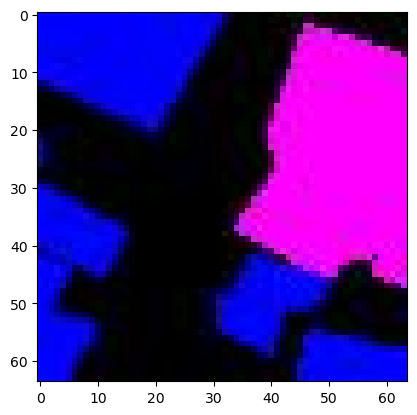

In [10]:
mask_dir = "C:/Users/kubaw/Desktop/DELFT/CORE/satellite_predictions/Dataset2/Masks/Destroyed"  
mask_filenames = masks.copy
mask_arrays = []


for filename in masks:
    # Construct the full path to the image
    mask_path = os.path.join(mask_dir, filename)

    # Read the image and convert it to RGB (OpenCV loads images in BGR by default)
    mask = cv2.imread(mask_path)
    mask_rgb = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

    # Append the image array to the list
    mask_arrays.append(mask_rgb)

# Display the first image array
plt.imshow(mask_arrays[idx])
plt.show()


In [11]:
def mask_to_2dim(mask_arrays):
    
    # takes a lists of 2 dim numpy arrays, 
    # returns 2dim torch tensor in form of 0 for background, 1 for undamaged, 2 for damaged
    masks_transformed = []
    

    # Define color thresholds for blue and magenta
    blue_lower = np.array([0, 0, 100], dtype=np.uint8)
    blue_upper = np.array([80, 80, 255], dtype=np.uint8)

    magenta_lower = np.array([120, 0, 120], dtype=np.uint8)
    magenta_upper = np.array([255, 100, 255], dtype=np.uint8)
    
    for mask_arr in mask_arrays: 
        
        
        # Create masks for blue and magenta regions
        blue_mask = cv2.inRange(mask_arr, blue_lower, blue_upper)
        magenta_mask = cv2.inRange(mask_arr, magenta_lower, magenta_upper)

        # Combine the masks to get the final transformed mask
        transformed_mask = np.zeros_like(blue_mask)
        transformed_mask[blue_mask > 0] = 1  # Object 1 (Blue)
        transformed_mask[magenta_mask > 0] = 2  # Object 2 (Magenta)
        
        masks_transformed.append(transformed_mask)
        
    # transform to torch tensort 
            
    masks_array = np.array(masks_transformed)
    masks_tensor = torch.from_numpy(masks_array)
    
    return masks_tensor

In [47]:
masks_transformed = mask_to_2dim(mask_arrays)


## 2. Create bounding boxes for

### 2.1 Test on one mask

In [13]:
# make test image and mask
img_torch = torch.from_numpy(np.array(img))
mask_torch = torch.from_numpy(np.array(transformed_mask))


img_test = img_torch.permute(2, 0, 1)
mask_test = mask_torch

print(img_test.size())
print(mask_test.size())

print_tensor = mask_test.numpy()

# Print the entire NumPy array
#np.set_printoptions(threshold=np.inf)
#print_tensor


torch.Size([3, 64, 64])
torch.Size([64, 64])


In [26]:
# use Connected Component Analysis to extract all objects from the image

mask_test, count = ski.measure.label(mask_test, connectivity=1, return_num=True)

mask_test = torch.from_numpy(np.array(mask_test))

# We get the unique colors, as these would be the object ids.
obj_ids = torch.unique(mask_test)

# first id is the background, so remove it.
obj_ids = obj_ids[1:]

# split the color-encoded mask into a set of boolean masks.
maskS_test = mask_test == obj_ids[:, None, None]

print(maskS_test.size())
obj_ids # count of objects on the image

torch.Size([6, 64, 64])


tensor([1, 2, 3, 4, 5, 6])

In [27]:
from torchvision.ops import masks_to_boxes

#make boxes (x1, x2, y1, y2)
boxes = masks_to_boxes(maskS_test)
print(boxes.size())
print(boxes)

torch.Size([6, 4])
tensor([[ 0.,  0., 31., 20.],
        [34.,  2., 63., 47.],
        [ 0., 23.,  0., 25.],
        [ 0., 30., 15., 63.],
        [31., 41., 50., 59.],
        [45., 55., 63., 63.]])


In [28]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

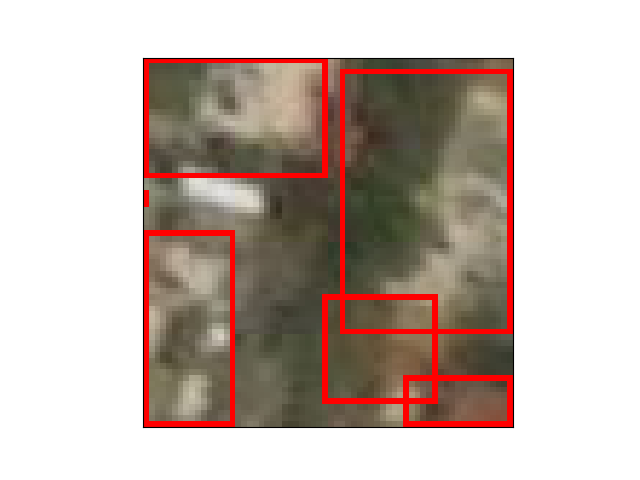

In [29]:

from torchvision.utils import draw_bounding_boxes

drawn_boxes = draw_bounding_boxes(img_test, boxes, colors="red")
show(drawn_boxes)

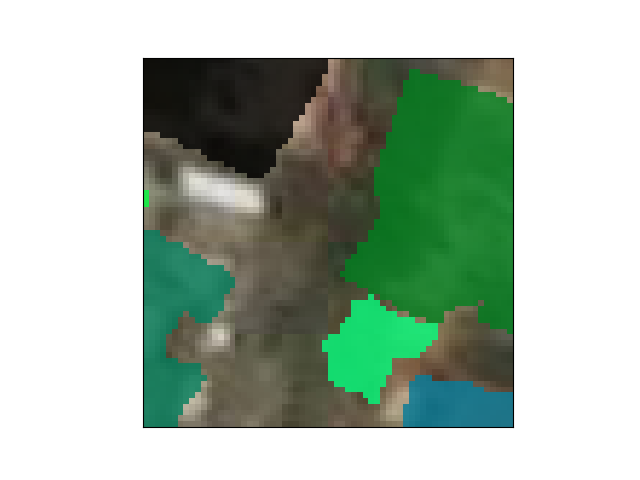

In [32]:
from torchvision.utils import draw_segmentation_masks
# visualise masks
drawn_masks = draw_segmentation_masks(img_test, maskS_test, alpha=0.8)
show(drawn_masks)

### 2.2 Make bounding boxes for all images

In [33]:
def mask_to_box(masks_transformed):
    
    boxes_list = []
    
    for mask in masks_transformed:
        
        mask, count = ski.measure.label(mask, connectivity=1, return_num=True)

        mask = torch.from_numpy(np.array(mask))
        # We get the unique colors, as these would be the object ids.
        obj_ids = torch.unique(mask)

        # first id is the background, so remove it.
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set of boolean masks.
        maskS_test = mask == obj_ids[:, None, None]
        
        boxes = masks_to_boxes(maskS_test)

        boxes_list.append(boxes)
        
    return boxes_list
        
#img_test = img_torch.permute(2, 0, 1)
#drawn_boxes = draw_bounding_boxes(img_test, boxes, colors="red")
#show(drawn_boxes)


In [45]:
# apply the function
bboxes = mask_to_box(masks_transformed)
bboxes

[tensor([[ 0., 24.,  7., 39.],
         [ 0., 26., 43., 63.],
         [36., 50., 52., 63.],
         [52., 57., 63., 63.]]),
 tensor([[ 0.,  8., 13., 35.],
         [ 2., 20., 53., 57.],
         [56., 53., 63., 63.]]),
 tensor([[ 0., 23., 31., 63.],
         [16., 36., 63., 63.],
         [32., 37., 32., 37.]]),
 tensor([[ 0.,  9., 46., 59.],
         [32., 31., 63., 63.]]),
 tensor([[ 0.,  0., 15., 31.],
         [ 0.,  6., 51., 54.],
         [40., 29., 63., 57.]]),
 tensor([[ 0.,  0., 17., 22.],
         [ 1., 13., 63., 63.]]),
 tensor([[ 6.,  0., 21.,  2.],
         [30.,  0., 58., 16.],
         [ 0., 20., 39., 63.],
         [32., 23., 54., 35.],
         [37., 35., 59., 63.],
         [ 0., 60.,  7., 63.],
         [46., 63., 46., 63.]]),
 tensor([[ 0.,  0., 63., 63.],
         [49.,  0., 63., 28.]]),
 tensor([[32.,  0., 63., 63.],
         [ 0.,  8., 20., 34.],
         [ 0., 44., 13., 60.]]),
 tensor([[ 5.,  0., 24.,  4.],
         [ 0.,  4., 39., 46.],
         [58.,  5., 6

## 3. Add labels to bounding boxes

In [44]:
bboxes_arr = np.asarray(bboxes, dtype="object")

pd.DataFrame(bboxes_arr)

,0
0,"[[tensor(0.), tensor(24.), tensor(7.), tensor(..."
1,"[[tensor(0.), tensor(8.), tensor(13.), tensor(..."
2,"[[tensor(0.), tensor(23.), tensor(31.), tensor..."
3,"[[tensor(0.), tensor(9.), tensor(46.), tensor(..."
4,"[[tensor(0.), tensor(0.), tensor(15.), tensor(..."
...,...
109,"[[tensor(38.), tensor(0.), tensor(45.), tensor..."
110,"[[tensor(0.), tensor(0.), tensor(1.), tensor(3..."
111,"[[tensor(0.), tensor(0.), tensor(43.), tensor(..."
112,"[[tensor(0.), tensor(0.), tensor(63.), tensor(..."
